Section 4. from "Piecewise exponential models for survival data with covariates" by Michael Friedman

In [56]:
from lifelines.datasets import load_lupus

df = load_lupus()

# preprocessing
T_col = 'time_between_diagnosis_and_last_observation_(years)'
E_col = 'dead'
df['time_elapsed_between_estimated_onset_and_diagnosis_binary'] = df['time_elapsed_between_estimated_onset_and_diagnosis_(months)'] <= 2*12
df['recent'] = df['year_month_of_diagnosis'] < '1951-07'

columns = ['is_male', 'is_white', 
           'age_at_diagnosis', 
           'time_elapsed_between_estimated_onset_and_diagnosis_binary',
           'recent'] + [T_col, E_col]

df = df[columns]
df = df.dropna() # drop the individual with NaN

# these models can naturally handle 0 durations, so we fudge a bit.
df.loc[df[T_col] == 0, T_col] = 0.000001
# add a constant column (only needed for non-Cox models.)
df['constant'] = 1.


In [57]:
from lifelines import PiecewiseExponentialRegressionFitter, CoxPHFitter


breakpoints = [
    [0.5, 0.8, 1.1, 1.7, 2.5, 3.1], 
    [0.3, 0.8, 1.0, 2.0, 3.0],
    [0.4, 0.9, 1.5, 2.5],
    [0.3, 1.0, 2.0, 3.0],
    [0.4],
    [0.3]
]

results = dict()
for i, bp in enumerate(breakpoints, start=1):
    # by forcing the penalizer to be 1000, the coefs between periods are constrainted to be identical. 
    pcf = PiecewiseExponentialRegressionFitter(penalizer=1000., breakpoints=bp)
    pcf.fit(df, T_col, E_col)
    # Note the negative sign. We use a different parameterization than the paper.
    results["model %d" % i] = -pcf.params_['lambda_0_'].drop('constant')
    
cph = CoxPHFitter().fit(df.drop('constant', axis=1), T_col, E_col)
results['Cox'] = cph.params_

In [58]:
results = pd.DataFrame(results).T

In [59]:
results

,is_male,is_white,age_at_diagnosis,time_elapsed_between_estimated_onset_and_diagnosis_binary,recent
model 1,-0.454013,-0.660882,0.001334,0.472303,1.096200
model 2,-0.449296,-0.664789,0.001070,0.435175,1.174195
model 3,-0.415715,-0.667667,0.000182,0.497052,1.086471
model 4,-0.423635,-0.637827,0.001707,0.409149,1.247443
model 5,-0.455248,-0.647714,0.001018,0.462002,1.145437
model 6,-0.445260,-0.638205,0.001007,0.456981,1.189638
Cox,-0.444981,-0.619252,0.000664,0.475423,1.144530


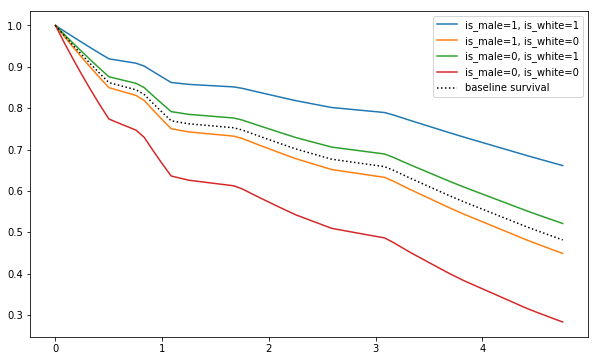

In [60]:
pcf = PiecewiseExponentialRegressionFitter(penalizer=1000., breakpoints=breakpoints[0])
pcf.fit(df, T_col, E_col)
pcf.plot_covariate_groups(['is_male', 'is_white'], [[1, 1], [1,0], [0, 1], [0, 0]], figsize=(10, 6))